# 0. File Setup

In [1]:
%load_ext rpy2.ipython

In [2]:
# Import required Python packages

import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
from scipy.interpolate import interp1d
import sys
import scipy.interpolate
matplotlib.use('agg')
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
import time
from rpy2.rinterface import rternalize
import rpy2.robjects
import warnings
warnings.filterwarnings('ignore')
from rpy2.robjects import r, pandas2ri

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

pandas2ri.activate()

In [3]:
rpy2.rinterface.initr()

In [4]:
%%R
# Import required R packages
library(easyNCDF)
library(schoolmath)
library(fields)
library(sp)
library(grid)
library(RColorBrewer)
library(ncdf4)
library(ggplot2)
library(plotly)
library(data.table)
library(Deriv)
library(RMThreshold)
library(Matrix)
library(doParallel)
library(abind)
library(plyr)
library(reticulate)

In [5]:
# Define the d13C contour characterisics
cmap = 'gist_rainbow'
d13C_color_min = -0.5
d13C_color_max = 1.25

# 1.0 Functions for sorting cores

In [6]:

def pl_cores(minn, maxx):

    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data
    indopac = pd.read_table("../Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("../Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("../Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df = indopac.append(atl)
    df = df.append(add)
    df = df.reset_index(drop = True)

    df['d18O names'] = df['Core'] + '_ageLS16.txt'
    df['d13C names'] = df['Core'] + '_d13C.txt'

    # Loop over the dataset and interpolate each core
    i = 0
    results_dict = {}

    while i < df.count()[0]:

        try:
            df_d18O = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('../Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue

        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue

        df_d13C = df_d13C.dropna(subset = ['age'])
        df_d13C = df_d13C.reset_index(drop = True)

        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        if len(df_d13C) > 0:
            df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
            df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

            df_d13C = df_d13C.drop(['depth'], axis = 1)

            df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            results_dict.update({
                df_results.Core[0] : df_results.drop(['Core'], axis = 1)
            })

        i += 1
        
    df_results = pd.concat(results_dict).reset_index()
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

In [7]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > minn]
    df = df[df['age'].astype(float) < maxx]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > minn]
    df2 = df2[df2['age'].astype(float) < maxx]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [8]:
@rternalize
def compile_cores(minn,maxx):
    df_pl = pl_cores(minn,maxx)
    df_oliver = Oliver_cores(minn,maxx)

    ###################3 join the dataframes
    
    df_results = df_pl.append(df_oliver)

    #################### get only the atlantic cores

    df = df_results.reset_index(drop = True)
    df['Dep'] = abs(df['Dep'])

    df_atl = df[df['Location'] == 'Atlantic']
    df_atl = df_atl.reset_index(drop = True)
    df_atl['age'] = df_atl.age.astype(float)

    # Group cores into distinct slices
    cores_grouped_dict = {}
    for key,group in df_atl.groupby('Core'):
        average_core = np.mean(group)
        average_core['std'] = np.std(group)['d13C']
        average_core['count'] = len(group)

        cores_grouped_dict.update({
            key : average_core
        })
    df_atl = pd.DataFrame.from_dict(cores_grouped_dict,orient='index')    
    df_atl = df_atl.reset_index().rename(columns={'index' : 'Core'})
    
    return(rpy2.robjects.DataFrame(df_atl))

# 2.0 Model Auxillary functions

In [9]:
%%R -o hyperbolic_tangent_func -o quadratic_func
# Equations defintions

hyperbolic_tangent_func <- function(a, b, c, e, Lat, Dep) {                                                                                                                                                                                  
    ( (A_mem - N_mem) * tanh(a*Lat + b*Dep + c*Dep**2 + e)  + A_mem + N_mem)/2}

quadratic_func <- function(a, b, c, e, Lat, Dep) {
   ( e + a*Lat + b*Dep + c*Dep**2 )}


In [10]:
%%R -o split 
# Depth Division Function

split <- function(lat, dep, df_c) {
    
    dep_4 <- dep[(dep > 2050) & (dep < 4000)]                                                                                                                                                                                                                       

    deps <- data.frame('dep_4' = dep_4)
    
    for (i in seq(1, nrow(deps), 1)) {
        
        df_c1 <- df_c[df_c[,c("Lat")] > lat_1 & df_c[,c("Lat")] < lat_3 & df_c[,c("Dep")] > deps[i,'dep_4'], ]
        df_c4 <- df_c[df_c[,c("Lat")] > lat_1 & df_c[,c("Lat")] < lat_3 & df_c[,c("Dep")] > dep_3 & df_c[,c("Dep")] < deps[i,'dep_4'], ]
        
        c1.avg <- mean(unlist(df_c1['d13C']))
        c1.tot <- sum((df_c1['d13C'] - c1.avg)**2)

        c4.avg <- mean(unlist(df_c4['d13C']))
        c4.tot <- sum((df_c4['d13C'] - c4.avg)**2)
        
        deps[i, 'c4'] <- c4.tot
        deps[i, 'c1'] <- c1.tot
        deps[i, 'c.tot'] <- c1.tot + c4.tot

    }

    deps <- deps[!duplicated(deps['dep_4']), ]                                                                                                                                                                                                                                                               

    min.loc <- deps['dep_4'][deps['c.tot'] == min(unlist(deps['c.tot']))]

    if (is.null(dep_4.spec)) {
        min.loc <- tail(min.loc,n=1)
    }
    else(
        min.loc <- dep_4.spec
    )
    
    return(min.loc) }


# 3.0 Model Function

In [11]:
%%R -i quadratic_func -i hyperbolic_tangent_func -o modelling

modelling <- function(equation, dep_4, repetitions, lat, dep, df_c, df.N, df.A) {
    
########################################################## 
#     print('into modelling function')
    if (equation == 'tanh') { 
        df_c4 <- df_c

        x_coord_min_4 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_4 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_4 <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
        y_coord_max_4 <- which(abs(dep - 6000) == min(abs(dep - 6000)))

    }
    
    if (equation == 'quad') {    

        df_c1 <- df_c[df_c[,c("Dep")] > (dep_4-500), ]
        df_c4 <- df_c[df_c[,c("Dep")] <= (dep_4+500), ]

        x_coord_min_1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_1 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_1 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
        y_coord_max_1 <- which(abs(dep - 6000) == min(abs(dep - 6000)))

        x_coord_min_4 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
        x_coord_max_4 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))

        y_coord_min_4 <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
        y_coord_max_4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
#         print(unique(df_c1$Dep))
    }
    
#################################################
    
    topography <-  (as.matrix(read.csv('Data/d13C_LOVECLIM_INTERP_hol.csv', header = FALSE)))*0 + 1

    x_coord_min_N <- which(abs(lat - lat_3) == (min(abs(lat - lat_3))))
    x_coord_max_N <- which(abs(lat - 70) == min(abs(lat - 70)))

    y_coord_min_N <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
    y_coord_max_N <- which(abs(dep - 3000) == min(abs(dep - 3000)))

    x_coord_min_A <- which(abs(lat + 60) == min(abs(lat + 60)))
    x_coord_max_A <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))

    y_coord_min_A <- which(abs(dep - dep_3) == min(abs(dep - dep_3)))
    y_coord_max_A <- which(abs(dep - 6000) == min(abs(dep - 6000)))

############################################

    
    N.data.mean <<- mean(unlist(df.N['d13C']))
    A.data.mean <<- mean(unlist(df.A['d13C']))
        
    if (is.null(N.EM.spec)) {
        N_mem <<- N.data.mean
    }
    else(
        N_mem <<- N.EM.spec
    )
   
    if (is.null(A.EM.spec)) {
        N_mem <<- A.data.mean
    }
    else(
        N_mem <<- A.EM.spec
    )
        
    lat.0.N <<- lat_3
    lat.0.A <<- lat_1
    
###########################################

    N.Mem.region <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    A.Mem.region <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_4 <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_N <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
    statmod_mask_A <- matrix(NA, nrow = dim(lat), ncol = dim(dep))

    if (equation == 'quad') {
        statmod_mask_1 <- matrix(NA, nrow = dim(lat), ncol = dim(dep))
        statmod_mask_1[x_coord_min_1:x_coord_max_1, y_coord_min_1:y_coord_max_1] <- 1 
        statmod_mask_1 <- statmod_mask_1 * topography}
    
    statmod_mask_4[x_coord_min_4:x_coord_max_4, y_coord_min_4:y_coord_max_4] <- 1 
    statmod_mask_4 <- statmod_mask_4 * topography

    N.Mem.region[x_coord_min_N:x_coord_max_N, y_coord_min_N:y_coord_max_N] <- N.data.mean 
    N.Mem.region <<- N.Mem.region * topography

    A.Mem.region[x_coord_min_A:x_coord_max_A, y_coord_min_A:y_coord_max_A] <- A.data.mean 
    A.Mem.region <<- A.Mem.region * topography

    statmod_mask_N[x_coord_min_N:x_coord_max_N, y_coord_min_N:y_coord_max_N] <- 1 
    statmod_mask_N <<- statmod_mask_N * topography

    statmod_mask_A[x_coord_min_A:x_coord_max_A, y_coord_min_A:y_coord_max_A] <- 1 
    statmod_mask_A <<- statmod_mask_A * topography
    

#######################################################

    lat.1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
    lat.3 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))
    
    statmod_mask_Nm <- statmod_mask_N
    statmod_mask_Am <- statmod_mask_A
    if (equation == 'quad') {statmod_mask_1m <- statmod_mask_1}
    statmod_mask_4m <- statmod_mask_4

    statmod_mask_Nm[lat.3,] <- 0
    statmod_mask_Am[lat.1,] <- 0

    statmod_mask_Nm[is.na(statmod_mask_Nm)] <- 0
    statmod_mask_Am[is.na(statmod_mask_Am)] <- 0
    if (equation == 'quad') {statmod_mask_1m[is.na(statmod_mask_1m)] <- 0}
    statmod_mask_4m[is.na(statmod_mask_4m)] <- 0
    
    if (equation == 'quad') {
        dep.4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
        statmod_mask_4m[,dep.4] <- 0
        total <- statmod_mask_1m + statmod_mask_4m + statmod_mask_Nm + statmod_mask_Am } else { total <- statmod_mask_4m + statmod_mask_Nm + statmod_mask_Am }
    
    total[total == 0 ] <- NA

    model_reduced_area <- total * as.matrix(read.csv('Data/d13C_LOVECLIM_INTERP_hol.csv', header = FALSE))

##################3 just the model data which is used
    
    if (equation == 'quad') {df.tot <- rbind(df.N, df.A, df_c1, df_c4)} else {df.tot <- rbind(df.N, df.A, df_c4)}

######################################################
#     print('up to modelling function')

    model_clust <- function(df, name, mask, count) {       ##########start model_clust
        
######################## 

        if (name == "AABW") {    
            output <- quadratic_func}
        
        if (name == 'Mixing' & equation == 'tanh') {
            output <- hyperbolic_tangent_func}

        if (name == 'Mixing' & equation == 'quad') {
            output <- quadratic_func}

##############################
        
        if (name == "AABW") {
            error_marker <<- 'AABW' }        
        
        if (name == 'Mixing' & equation == 'quad') {
            error_marker <<- 'NADW'}

################## Apply NLS function, running through random starting variables between -0.01 and 0.01 until it works..
        
        solver <<- 'port'
        min.fact <<- 2^(-30)
        tol <<- 1e-10 ########changed this
        sigs <<- 4
        
    success = FALSE
    while (!success) {

        nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, weights = df[, 'count']**0.5, start = list(a = runif(1, min = -1, max= 1)/100, b = runif(1, min = -1, max= 1)/100, c = runif(1, min = -1, max= 0)/100, e = runif(1, min = -1, max= 1)/100), control = nls.control(minFactor = min.fact, tol = tol*100, warnOnly = TRUE), upper = list(a = 10000, b = 10000, c = 0, e = 10000)))
#                        nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, start = list(a = runif(1, min = -1, max= 1)/100, b = runif(1, min = -1, max= 1)/100, c = runif(1, min = -1, max= 0)/100, e = runif(1, min = -1, max= 1)/100), control = nls.control(minFactor = min.fact, tol = tol*100, warnOnly = TRUE), upper = list(a = 10000, b = 10000, c = 0, e = 10000)))

#               nlsfit <- try(nls(d13C ~ output(a, b, c, e, Lat, Dep), df, weights = df[, 'age_weights'], start = list(a = 0, b = 0, c = 0, e = 0), control = nls.control(minFactor = min.fact, tol = tol, warnOnly = FALSE)))

            #### df[, 'count'] is sometimes called df[,'age_weights']

        if (!("try-error" %in% class(nlsfit))) {success = TRUE}
    }

####################	 

        params.to.save <- signif(data.frame(summary(nlsfit)$coeff), sigs)
        params.to.save['Std..Error'] <- params.to.save['Std..Error']/params.to.save['Estimate']
        
        a <- coef(nlsfit)['a']
        b <- coef(nlsfit)['b']
        c <- coef(nlsfit)['c']
        e <- coef(nlsfit)['e']
        
#################

        df$pred.d13C <- output(a, b, c, e , df$Lat, df$Dep)
        df$resids <- df$d13C - df$pred.d13C

        df2 <- matrix(,nrow = dim(dep), ncol = dim(lat))
        
####################
        
        for (value in seq(1,nrow(lat),1)){df2[,value] <- output(a, b, c, e, rep(lat[value], dim(dep)), dep)}
    
        df2 <- t(df2) * mask

#################### export the results

        forexport <- df2    
        forexport[ is.nan(forexport) ] <- 0
        forexport[ is.na(forexport) ] <- 0
        
        if (name == "AABW") {

            a.AABW <<- a
            b.AABW <<- b
            c.AABW <<- c
            e.AABW <<- e

        sigma.aabw <<- summary(nlsfit)$sigma
        n <<- nrow(df)

            AABW.region <<- forexport}
        
        if (name == 'Mixing') {

            a.NADW <<- a
            b.NADW <<- b
            c.NADW <<- c
            e.NADW <<- e
            
            N.Mem.region[ is.na(N.Mem.region) ] <- 0
            A.Mem.region[ is.na(A.Mem.region) ] <- 0
            
            NADW.region <<- forexport

            
            if (equation == 'quad') {

            sigma.mixing <<- (sigma.aabw * (n - 2) +  summary(nlsfit)$sigma * (nrow(df) - 2)) / (n + nrow(df) - 2)

                dep.4 <- which(abs(dep - dep_4) == min(abs(dep - dep_4)))
                NADW.region[,dep.4] <- 0

                total <- NADW.region + AABW.region } else {
                    sigma.mixing <<- summary(nlsfit)$sigma

                    lat.1 <- which(abs(lat - lat_1) == min(abs(lat - lat_1)))
                    lat.3 <- which(abs(lat - lat_3) == min(abs(lat - lat_3)))
                                                       
                    N.Mem.region[lat.3,] <- 0
                    A.Mem.region[lat.1,] <- 0    

                    total <- NADW.region + A.Mem.region + N.Mem.region }
            
            total[total == 0 ] <- NA   
        }
        return(total)
    }
    
###########3running model_clust function

    if (equation == 'tanh') {
        cluster_name <- list("Mixing")
        cluster_num <- 1 
        cluster_list <- list(df_c4)
        mask <- list(statmod_mask_4)}
    
    if (equation == 'quad') {
        cluster_name <- list("AABW", "Mixing")
        cluster_num <- 2
        cluster_list <- list(df_c1, df_c4)
        mask <- list(statmod_mask_1, statmod_mask_4) }    
    
    for (count in seq(1, cluster_num, 1)) {            
        total <- model_clust(cluster_list[[count]], cluster_name[[count]], mask[[count]], count)}

    if (equation == 'quad'){
        stats <- data.frame(sigma = sigma.mixing, N_mem = N.data.mean, A_mem = A.data.mean, a.AABW = a.AABW, b.AABW = b.AABW, c.AABW = c.AABW, e.AABW = e.AABW, a.NADW = a.NADW, b.NADW = b.NADW, c.NADW = c.NADW, e.NADW = e.NADW)
    }
        
    if (equation == 'tanh'){
        stats <- data.frame(sigma = sigma.mixing, N_mem = N.data.mean, A_mem = A.data.mean, a.AABW = NA, b.AABW = NA, c.AABW = NA, e.AABW = NA, a.NADW = a.NADW, b.NADW = b.NADW, c.NADW = c.NADW, e.NADW = e.NADW)
    }

    return(list(samples = df.tot, statmod = total, stats = stats))
}


# 4.0 Loop function over model function

In [12]:
%%R -o loop_func

loop_func <- function(input) {     

    intersect <- TRUE

    # Import the data using python
    df <- df_original
    #df <- compile_cores(input[, 'slice'][[1]][1], input[, 'slice'][[1]][2])
    
    #################  Get the cores list

    df_Hol <- compile_cores(3,5)
    df_LIG <- compile_cores(120,125)

    # Find the list of cores that are both in the Holocene and the LIG
    common_core_list <- intersect(df_Hol[,'Core'], df_LIG[,'Core'])  
    
    # Find the intersection bewteen Holocene and LIG

    if (intersect == TRUE) {
    df <- df[df$Core %in% common_core_list,]
    }
    
    # SELECT A RANDOM ROW, STORE IT, AND THEN DROP IT (FOR BOOTSTRAPPING)
    my.sample.index <- sample(seq(1,nrow(df)),1)
    dropped.sample <- df[my.sample.index,]    
    df <- df[seq(1,nrow(df))[seq(1,nrow(df)) != my.sample.index],]    
        
    # Get region boundaries
    params <- read.table('Data/box_params.txt', header = TRUE)
    
    if (is.null(dep_3.spec)) {
        dep_3 <<- params[params$para == 'dep_3_UVic', ]$value
    }
    else(
        dep_3 <<- dep_3.spec )
        
    if (is.null(lat_1.spec)) {
        lat_1 <<- params[params$para == 'lat_1', ]$value
    }
    else(
        lat_1 <<- lat_1.spec )
        
    if (is.null(lat_3.spec)) {
        lat_3 <<- params[params$para == 'lat_3', ]$value
    }
    else(
        lat_3 <<- lat_3.spec   )     


    # Get latitude-depth grid points
    
    #dep_grid <- abs(array(read.csv('Data/depth_levels.csv', header = FALSE)$V1))
    #lat_grid <- array(read.csv('Data/latitude_levels.csv', header = FALSE)$V1)
    
    # Divide up dataframe based on regions
    
    df_c <- df[df[,c("Lat")] > lat_1 & df[,c("Lat")] < lat_3 & df[,c("Dep")] > dep_3, ]
    df.N <- df[df[,c("Lat")] > lat_3 & df[,c("Lat")] < 70 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 3000 , ]
    df.A <- df[df[,c("Lat")] > -60 & df[,("Lat")] < lat_1 & df[,c("Dep")] > dep_3 & df[,c("Dep")] < 6000 , ]
#     print('defined regions')
###################################   
    
    success = FALSE
    while (!success) { 

#         print('divided')
        
        if (input[, 'equation'] == 'quad' ) {
            
            attempt_rand <- try(input[, 'dep_4'] <- split(lat_grid, dep_grid, df_c))
            
        }
        if (input[,'equation'] == 'tanh' ) {
            attempt_rand <- NA
            input[, 'dep_4'] <- NA
        }
        
#         print('completed Split running func')
        
        if (!("try-error" %in% class(attempt_rand))) {
#             print('successful split function')
            
            attempt_model<- try(output <- modelling(input[, 'equation'], input[, 'dep_4'], input[, 'reps'], lat_grid, dep_grid, df_c, df.N, df.A ))

            if(!("try-error" %in% class(attempt_model))) {
#                 print('successful modelling')
                success = TRUE
            }
        }
    }

#     print('modeling complete')
        
    filename <- paste(input[, 'reps'], input[, 'equation'], sep = '_')
        
    input[, 'filename'] <- paste(filename, "d13C.txt", sep = '_')
    input[, 'success.rate'] <- success
    
    if(!success) {
        output = list()
        output$statmod <- matrix(NA, nrow = length(lat), ncol = length(dep))
        output$samples <- data.frame(NA)
        output$stats <- data.frame(sigma = NA, N_mem = NA, A_mem = NA, a.AABW = NA, b.AABW = NA, c.AABW = NA, e.AABW = NA, a.NADW = NA, b.NADW = NA, c.NADW = NA, e.NADW = NA)}

    rownames(output$stats) <- NULL
    rownames(input) <- NULL
    input <- merge(input, output$stats, by = 0)
    
    output$samples$run.no <- rep(input[,'run.no'], times = nrow(output$samples))

#     print('output made')
#     print(' ')
    
    return(list(df = input, statmod = output$statmod, samples = output$samples, dropped.sample=dropped.sample))
    
}


# 5.0 Model R Setup

In [13]:
%%R -i loop_func -i compile_cores

# Import all the required packages

setup_function <- function(lat_grid,dep_grid,df, time_min, time_max,
                           N.EM.spec=NULL,A.EM.spec=NULL,dep_4.spec=NULL,
                           lat_1.spec=NULL,lat_3.spec=NULL,dep_3.spec=NULL) {

    N.EM.spec <<- N.EM.spec
    A.EM.spec <<- A.EM.spec
    dep_4.spec <<- dep_4.spec
    lat_1.spec <<- lat_1.spec
    lat_3.spec <<- lat_3.spec
    dep_3.spec <<- dep_3.spec    
    
    
    lat_grid <<- lat_grid
    dep_grid <<- dep_grid
    df_original <<- df

    options(warn=-1)

    # Get information on cores for parallelisation

    # no_cores <- detectCores()
    # clust <- makeCluster(no_cores, outfile = 'log.txt')
    # registerDoParallel(clust)
    # writeLines(c(""), "log.txt")

    # Set up the conditions to model

    equation <- c('quad')

    resolution <- 1 # The number of years to move up by in each slice
    lower <- time_min
    upper <- time_max
    slice <- mapply(c, lower, upper, SIMPLIFY=FALSE)

    # Number of times to repeat the above simulations
    repetitions <- 1

    # Compile all of these setup conditions into an model input array
    input <- expand.grid(equation = equation, slice = slice, reps = repetitions)
    input$run.no <- rownames(input)

    # Create functions for extracting the different outputs from foreach function 
    acombstatmod <- function(...)  abind(...$statmod, along = 3)
    rcombdf <- function(...) rbind(...$df)
    rcombsmp <- function(...) rbind(...$samples)
    rcombdrpsmp <- function(...) rbind(...$dropped.sample)    
    
    # Run each row in the input array in parallel
    output <- foreach(i = 1:nrow(input)) %do% {loop_func(input[i,])}

    # Extract the results
    model_output <- array(as.numeric(unlist(lapply(output, acombstatmod))), dim = c(160, 120, nrow(input))) #Mean response of the statistical models
    df_results_summary <- do.call(rbind, lapply(lapply(output, rcombdf), data.frame, stringsAsFactors = FALSE)) #Summary of the statistical models
    samples <- rbind.fill(lapply(output, rcombsmp)) #Dataframe of the samples used for modelling
    dropped.sample <- rbind.fill(lapply(output, rcombdrpsmp)) #Dataframe of the samples used for modelling    
    
    # Break down time slice column into two columns, remove old 'slice' column
    time.sep <- function(...) (unlist(...))
    times <- lapply(df_results_summary['slice'], time.sep)
    lower <- times$slice[seq(1, length(times$slice), 2)]
    upper <- times$slice[seq(2, length(times$slice), 2)]
    df_results_summary$lower <- lower
    df_results_summary$upper <- upper
    drops <- c('slice')
    df_results_summary <- df_results_summary[ , !(names(df_results_summary) %in% drops)]
    
    return(list('samples'=samples, 'summary'=df_results_summary, 'output'=model_output, 'dropped.sample'=dropped.sample))
    }


# 6.0 Load the data

In [14]:
# Import standardised latitudes and depths
lat_grid = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_grid = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')

In [15]:
# Load Some UVic Data for calculating the d13C of Atlantic Basin
fh = Dataset('/srv/ccrc/data06/z5145948/UVic/PI/tavg.09920.01.01.nc')

o_dic13 = fh.variables['O_dic13'][:]
dep_U = fh.variables['depth'][:]
lon_U = fh.variables['longitude'][:]
lat_U = fh.variables['latitude'][:]

mask_U = o_dic13 / o_dic13

# #### import some UVic data

# # Set up graph

dep = dep_grid
lat = lat_grid                                                                                                                                                                                                                     

# # Adjust the mask

mask_U_original = mask_U.copy()

mask_U = np.mean(mask_U, axis = 0)

X, Y = np.meshgrid(dep_U, lat_U)
XI, YI  = np.meshgrid(dep, lat)

new_mask = np.empty((len(lon_U), len(lat), len(dep)))

for i in  np.arange(0, mask_U[0,0,:].shape[0]):
    mask_regridded_U = scipy.interpolate.griddata((X.flatten(), Y.flatten()), (mask_U[:,:,i].T).flatten() , (XI, YI),method='linear')
    new_mask[i,:,:] = mask_regridded_U

new_mask = new_mask.T
mask_U = new_mask
mask_U = np.ma.masked_where(mask_U == 0, mask_U)

mask = mask_U
lon = lon_U


# 7.0 Run Experiments

In [16]:
Hol_min = 3.0
Hol_max = 5.0
LIG_min = 120.0
LIG_max = 125.0

In [17]:
# %%R -i df_Hol -i Hol_min -i Hol_max -i lat_grid -i dep_grid -o Hol_samples_d4s -o Hol_model_output_d4s -o Hol_summary_d4s -o Hol_dropped_sample_d4s
 
# # Define lists to fille
# Hol_samples_d4s = c()
# Hol_model_output_d4s = c()
# Hol_summary_d4s = c()
# Hol_dropped_sample_d4s = c()

# for (i in seq(1,2)){ 
    
#     # Run model function
#     Hol_d4s <- setup_function(lat_grid,dep_grid,df_Hol,Hol_min,Hol_max,
#                                       dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)
#     # extract values from output
#     Hol_samples_d4s_inst <- Hol_d4s$samples
#     Hol_model_output_d4s_inst <- Hol_d4s$output
#     Hol_summary_d4s_inst <- Hol_d4s$summary
#     Hol_dropped_sample_d4s_inst <- Hol_d4s$dropped.sample
    
#     # append final values to the list
#     Hol_samples_d4s[toString(i)] <- Hol_samples_d4s_inst
#     Hol_model_output_d4s[i] <- Hol_model_output_d4s_inst
#     Hol_summary_d4s[i] <- Hol_summary_d4s_inst
#     Hol_dropped_sample_d4s[i] <- Hol_dropped_sample_d4s_inst
# }
    
    

In [18]:
# %%R -i df_LIG -i LIG_min -i LIG_max -i lat_grid -i dep_grid -o LIG_samples_d4s -o LIG_model_output_d4s -o LIG_summary_d4s -o LIG_dropped_sample_d4s
 
# LIG_d4s <- setup_function(lat_grid,dep_grid,df_LIG,LIG_min,LIG_max,
#                                   dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)

# LIG_samples_d4s <- LIG_d4s$samples
# LIG_model_output_d4s <- LIG_d4s$output
# LIG_summary_d4s <- LIG_d4s$summary
# LIG_dropped_sample_d4s <- LIG_d4s$dropped.sample


In [19]:
# Get Core Compilation
df_Hol = compile_cores(Hol_min,Hol_max)

# Define lists to fille
Hol_samples_d4s = []
Hol_model_output_d4s = []
Hol_summary_d4s = []
Hol_dropped_sample_d4s = []

for i in np.arange(0,100,1):
    
    # Load variables from Python to R
    %R -i df_Hol -i Hol_min -i Hol_max -i lat_grid -i dep_grid
    
    # Run model function
    %R Hol_d4s <- setup_function(lat_grid,dep_grid,df_Hol,Hol_min,Hol_max,dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)
    # extract values from output
    %R Hol_samples_d4s_inst <- Hol_d4s$samples
    %R Hol_model_output_d4s_inst <- Hol_d4s$output
    %R Hol_summary_d4s_inst <- Hol_d4s$summary
    %R Hol_dropped_sample_d4s_inst <- Hol_d4s$dropped.sample
    
    # send values to the python
    %R -o Hol_samples_d4s_inst
    %R -o Hol_model_output_d4s_inst
    %R -o Hol_summary_d4s_inst
    %R -o Hol_dropped_sample_d4s_inst
    
    # append to python list
    Hol_samples_d4s.append(Hol_samples_d4s_inst)
    Hol_model_output_d4s.append(Hol_model_output_d4s_inst)
    Hol_summary_d4s.append(Hol_summary_d4s_inst)
    Hol_dropped_sample_d4s.append(Hol_dropped_sample_d4s_inst)
    


In [20]:
# Get Core Compilation
df_LIG = compile_cores(LIG_min,LIG_max)

# Define lists to fille
LIG_samples_d4s = []
LIG_model_output_d4s = []
LIG_summary_d4s = []
LIG_dropped_sample_d4s = []

for i in np.arange(0,100,1):
    
    # Load variables from Python to R
    %R -i df_LIG -i LIG_min -i LIG_max -i lat_grid -i dep_grid    
    
    # Run model function
    %R LIG_d4s <- setup_function(lat_grid,dep_grid,df_LIG,LIG_min,LIG_max,dep_4.spec=3500,lat_1.spec=-50,lat_3.spec=55)
    # extract values from output
    %R LIG_samples_d4s_inst <- LIG_d4s$samples
    %R LIG_model_output_d4s_inst <- LIG_d4s$output
    %R LIG_summary_d4s_inst <- LIG_d4s$summary
    %R LIG_dropped_sample_d4s_inst <- LIG_d4s$dropped.sample
    
    # send values to the python
    %R -o LIG_samples_d4s_inst
    %R -o LIG_model_output_d4s_inst
    %R -o LIG_summary_d4s_inst
    %R -o LIG_dropped_sample_d4s_inst
    
    # append to python list
    LIG_samples_d4s.append(LIG_samples_d4s_inst)
    LIG_model_output_d4s.append(LIG_model_output_d4s_inst)
    LIG_summary_d4s.append(LIG_summary_d4s_inst)
    LIG_dropped_sample_d4s.append(LIG_dropped_sample_d4s_inst)
     


# 8.0 Sensitivity Analyses

In [31]:
LIG_summary_d4s

[  Row.names equation  reps run.no   dep_4         filename  success.rate  \
 0         1     quad   1.0      1  3500.0  1_quad_d13C.txt             1   
 
      sigma     N_mem  A_mem   a.AABW    b.AABW        c.AABW    e.AABW  \
 0  0.20165  0.639196    NaN  0.00524  0.001455 -2.093746e-07 -1.893855   
 
      a.NADW    b.NADW        c.NADW    e.NADW  lower  upper  
 0  0.005319  0.000418 -7.526551e-08  0.080998  120.0  125.0  ,
   Row.names equation  reps run.no   dep_4         filename  success.rate  \
 0         1     quad   1.0      1  3500.0  1_quad_d13C.txt             1   
 
       sigma     N_mem  A_mem    a.AABW    b.AABW        c.AABW    e.AABW  \
 0  0.203432  0.639196    NaN  0.004801  0.001359 -1.997407e-07 -1.677599   
 
      a.NADW    b.NADW        c.NADW    e.NADW  lower  upper  
 0  0.005613  0.000375 -6.720160e-08  0.120667  120.0  125.0  ,
   Row.names equation  reps run.no   dep_4         filename  success.rate  \
 0         1     quad   1.0      1  3500.0  1_qua

In [103]:
# Create lists to make a histogram in the spread of the results

######Holocene

min_list = []
max_list = []
mean_list = []

for single_array in Hol_model_output_d4s:
    min_list.append(np.nanmin(single_array))
    max_list.append(np.nanmax(single_array))
    mean_list.append(np.nanmean(single_array))    
    
# Make into dataframe
df_results_spread_Hol = pd.DataFrame({'min':min_list,'max':max_list,'mean':mean_list})    

# LIG
min_list = []
max_list = []
mean_list = []

for single_array in LIG_model_output_d4s:
    min_list.append(np.nanmin(single_array))
    max_list.append(np.nanmax(single_array))
    mean_list.append(np.nanmean(single_array))    
    
# Make into dataframe
df_results_spread_LIG = pd.DataFrame({'min':min_list,'max':max_list,'mean':mean_list})    

In [104]:
%%R -i df_results_spread_LIG

print(summary(df_results_spread_LIG))
print('')
print(sd(df_results_spread_LIG$mean))

      min               max              mean       
 Min.   :-0.3264   Min.   :0.9354   Min.   :0.5346  
 1st Qu.:-0.1838   1st Qu.:0.9524   1st Qu.:0.5429  
 Median :-0.1791   Median :0.9528   Median :0.5460  
 Mean   :-0.1785   Mean   :0.9796   Mean   :0.5522  
 3rd Qu.:-0.1771   3rd Qu.:0.9557   3rd Qu.:0.5469  
 Max.   : 0.1009   Max.   :1.8199   Max.   :0.7625  
[1] ""
[1] 0.03777591


In [105]:
%%R -i df_results_spread_Hol

print(summary(df_results_spread_Hol))
print('')
print(sd(df_results_spread_Hol$mean))

      min                max             mean       
 Min.   :-0.08237   Min.   :1.049   Min.   :0.6734  
 1st Qu.: 0.09157   1st Qu.:1.080   1st Qu.:0.6841  
 Median : 0.10765   Median :1.081   Median :0.6867  
 Mean   : 0.08892   Mean   :1.093   Mean   :0.6921  
 3rd Qu.: 0.10767   3rd Qu.:1.081   3rd Qu.:0.6870  
 Max.   : 0.13981   Max.   :1.370   Max.   :0.8346  
[1] ""
[1] 0.02992531


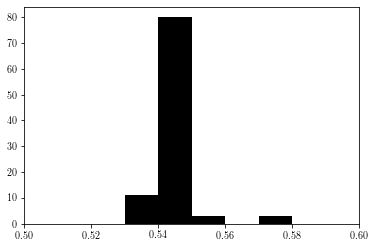

In [93]:
# 
#output_min = plt.hist(list(df_results_spread['min']),bins=bins,color='r')
#output_max = plt.hist(df_results_spread['max'],bins=bins,color='b')
output_mean = plt.hist(df_results_spread['mean'],bins=bins,color='k')

#plt.legend([output_min, output_max, output_mean],labels=['min','max','mean'])

plt.xlim(0.5,0.6)

plt.show()

In [78]:
np.min(min_list), np.max(max_list)

(-0.3263513963771567, 1.8198948610949457)

In [27]:

N_mem_list = []
for x in LIG_summary_d4s:
    N_mem_list.append(x['N_mem'][0])

In [28]:
np.unique(N_mem_list)

array([0.59142857, 0.59416667, 0.63919643, 0.6822619 , 0.68892857])

In [29]:
A_mem_list = []
for x in LIG_summary_d4s:
    A_mem_list.append(x['A_mem'][0])

In [30]:
A_mem_list

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]